# Incremental KMeans value simulator

This notebook simulates a KMeans problem and allows to evaluate the best parameters. The function "evaluate" returns the inertia value for all runs. The simulated problem has the following parameters:
* `n_samples`, `n_features`: Generated data has shape (n_samples, n_features). To simulate CIFAR10, use (50000x512).
* `n_repeat`: How many times the experiment is repeated
* `n_blobs`: How many blobs are generated in the data. This is used because the number of blobs is different from the number of cluster we have in active learning. CIFAR 10 has 10 blobs but we select 1k samples in it. So, for CIFAR10, use 10.
* `n_clusters`: The number of clusters to look for. It includes the fixed clusters.
* `n_fixed_clusters`: The number of clusters to keep fixed. The clusters kept fixed are the first ones in the list of centers returned by the function `make_blobs`.
* `reassignment_ratio`: See MiniBatchKMeans documentation.
* `recenter_every`: When different than None, it allows all the centers to move but it regularly stick centers to the fixed_cluster_center positions. The goal is to avoid having fixed cluster blocking the whole optimization process.

In [1]:
import numpy as np
from cardinal.kmeans import IncrementalMiniBatchKMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import make_blobs
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import ttest_rel

In [2]:
def evaluate(n_samples, n_repeat, n_features, n_blobs, n_clusters,
             n_fixed_clusters, reassignment_ratio, recenter_every):
    inertiae = []
    for i in range(n_repeat):
        X, y, centers = make_blobs(
            centers=n_blobs,
            return_centers=True,
            n_features=n_features,
            random_state=i)
        clus = IncrementalMiniBatchKMeans(
            n_clusters=n_clusters,
            reassignment_ratio=reassignment_ratio
        )
        kwargs = dict()
        kwargs['fixed_cluster_centers'] = None
        if n_fixed_clusters > 0:
            kwargs['fixed_cluster_centers'] = centers[:n_fixed_clusters]
        kwargs['recenter_every'] = recenter_every
        clus.fit(X, **kwargs)
        inertiae.append(clus.inertia_)
    return inertiae

def compare(a, b):
    return ttest_rel(a, b)
    

In [3]:
def plot(xlabel, ylabel, values, inerts):
    arr = np.asarray(inerts)
    for i in range(arr.shape[1]):
        plt.scatter(values, arr[:, i], alpha=.2, c='gray')
    plt.plot(values, np.mean(arr, axis=1), c='r')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

# Varying the parameters

Let us take a synthetic example to start with and vary the value of the parameters to observe the effect on the prediction performance.

We chose an example with:
5000 samples, 20 dimensions, 100 repetitions, 10 blobs and 10 clusters.

## Varying fixed cluster centers

KMeans is meant to minimize inertia. The more points we keep fixed, the higher we expect the resulting inertia to be.

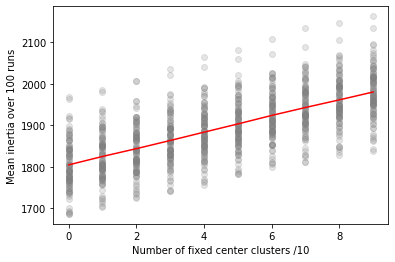

In [4]:
# Fixed cluster centers

study_value = []
study_inert = []

for i in range(10):
    study_value.append(i)
    inert = evaluate(5000, 100, 20, 10, 10, i, 0.01, None)
    study_inert.append(inert)
    
plot('Number of fixed center clusters /10', 'Mean inertia over 100 runs', study_value, study_inert)

This experiment confirms our intuition. For the rest of this notebook, we set the number of fixed clusters at 5.

## Varying the reassignment ratio

In our blog post, we evocked the possibility for IWKMeans to get in the way of KMeans optimization. However, the clever kmeans++ initialization together with automatic reassignement of centers in low density areas of MIniBatchKMeans should take care of this problem. We verify this intuition by varying the reassignment ratio.

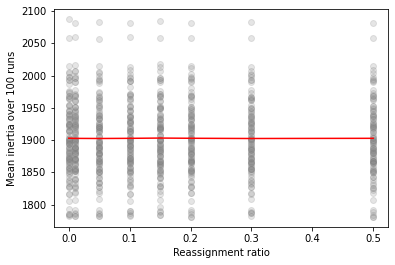

In [5]:
study_value = []
study_inert = []

for i in [0., 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5]:
    study_value.append(i)
    inert = evaluate(5000, 100, 20, 10, 10, 5, i, None)
    study_inert.append(inert)
    
plot('Reassignment ratio', 'Mean inertia over 100 runs', study_value, study_inert)

We observe that even when the reassignment is disabled, IWKMeans manages to converge. We keep a value of 0.1 as reassignment ratio for the next experiment.

## Varying recentering frequency

This experiment asks the question: What if we just initilize the KMeans to known position, but do not touch them afterward? We test it by varying the frequency of "recentering". We call "recentering" the operation of taking the centers closest to our fixed positions and "moving" them in this spot. In the original IWKMeans, centers cannot move, so this question is not be asked. In this relaxed version, all centers can move but are regularly set back to our fixed positions. In its extreme version, we do the recentering only once at the end of the optimization.

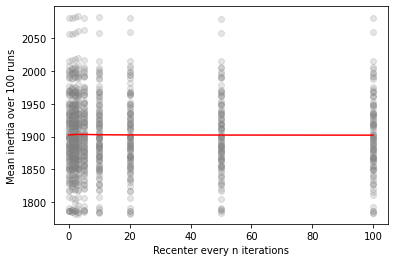

In [20]:
# Fixed cluster centers

study_value = []
study_inert = []

for i in [None, 1, 2, 3, 5, 10, 20, 50, 100]:
    study_value.append(i if i is not None else 0)
    inert = evaluate(5000, 100, 20, 10, 10, 5, 0.1, i)
    study_inert.append(inert)
    
plot('Recenter every n iterations', 'Mean inertia over 100 runs', study_value, study_inert)

We observe no difference on these strategies. This is not surprising on such a simple synthetic example.

# CIFAR10-like experiment

We now consider a problem that is closer to a real life one. Note that computation time are in order of minutes in this section.

50000 samples, 512 features, 10 repetitions, 10 blobs (for the 10 classes), 2000 clusters including 1000 fixed (mimic the first active learning iteration).

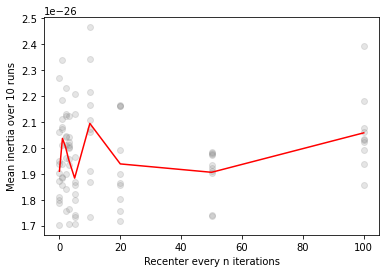

In [7]:
# Fixed cluster centers

study_value = []
study_inert = []

for i in [None, 1, 2, 3, 5, 10, 20, 50, 100]:
    study_value.append(i if i is not None else 0)
    inert = evaluate(50000, 10, 512, 10, 2000, 1000, 0.01, i)
    study_inert.append(inert)
    
plot('Recenter every n iterations', 'Mean inertia over 10 runs', study_value, study_inert)

We see that in a more complex case, the result seems to be less clear. Given that the algorithm with fixed centers (recenter_every=0) seems to yield the optimal result and is the least computationally expensive, given that the position of the centers is not updated, it seems to remain the best option.

# Visual comparison of IWKMeans vs KMeans

We now set up an experiment in 2 dimensions to be able to visualize the outcome of the algorithms.

Text(0.5, 1.0, 'Ground truth')

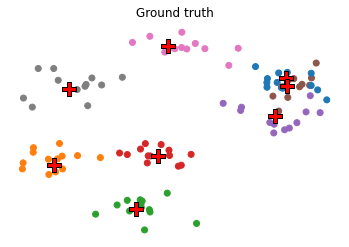

In [36]:
n_dimensions = 2
n_fixed_clusters = 4

X, y, centers = make_blobs(centers=8, return_centers=True, n_features=n_dimensions, random_state=1)

if n_dimensions == 1:
    X = np.vstack([X[:, 0], np.ones(X.shape[0])]).T
    centers = np.vstack([centers[:, 0], np.ones(centers.shape[0])]).T
    
plt.scatter(X[:, 0], X[:, 1], c=['C{}'.format(i) for i in y])
plt.scatter(centers[:, 0], centers[:, 1], c='red', edgecolors='k', marker='P', s=200)
plt.axis('off')
plt.title('Ground truth')

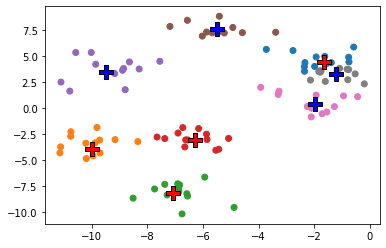

In [39]:
iwkmeans = IncrementalMiniBatchKMeans(n_clusters=8, reassignment_ratio=0)

iwkmeans.fit(X, fixed_cluster_centers=centers[:4])
iwkmeans.predict(X)

colors = ['C{}'.format(i) for i in iwkmeans.predict(X)]

plt.scatter(X[:, 0], X[:, 1], c=colors)
iwkc = iwkmeans.cluster_centers_
plt.scatter(iwkc[:n_fixed_clusters, 0], iwkc[:n_fixed_clusters, 1], c='red', edgecolors='k', marker='P', s=200)
plt.scatter(iwkc[n_fixed_clusters:, 0], iwkc[n_fixed_clusters:, 1], c='blue', edgecolors='k', marker='P', s=200)

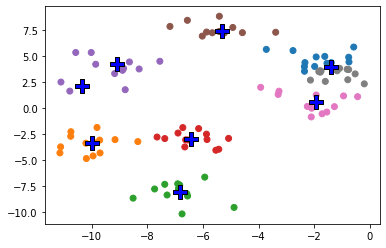

In [40]:
kmeans = MiniBatchKMeans(n_clusters=8, reassignment_ratio=0)

kmeans.fit(X)
kmeans.predict(X)

colors = ['C{}'.format(i) for i in iwkmeans.predict(X)]

plt.scatter(X[:, 0], X[:, 1], c=colors)
kc = kmeans.cluster_centers_
plt.scatter(kc[:, 0], kc[:, 1], c='blue', edgecolors='k', marker='P', s=200)


In term of inertia, the regular KMeans is better, but in term of distance to the original centers, IWKMeans is closer since it already knows half of it. In that sense, Incremental Kmeans can be seen as a way to apply a prior over a clustering problem.

In [41]:
from sklearn.metrics import pairwise_distances_argmin_min


print('Distance to original centers')
print('IWKmeans:', pairwise_distances_argmin_min(centers, iwkc)[1].sum())
print('Kmeans:', pairwise_distances_argmin_min(centers, kc)[1].sum())

Distance to original centers
IWKmeans: 1.5046742439537497
Kmeans: 3.672875892398636
